In [1]:
# Python Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as trans

In [2]:
# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Labels

In [3]:
train_split_df = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")
test_split_df = pd.read_csv("../input/fashionmnist/fashion-mnist_test.csv")

In [4]:
train_split_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# list(train_split_df['label'].values)

In [6]:
# list(train_split_df.drop(['label'], axis=1).values)

# Preprocessing

In [7]:
class PyTorchFMNISTDataset(Dataset):
    
    def __init__(self, data, transform):
        self.transform = transform
        
        label = list(data['label'].values)
        image = list(data.drop(['label'], axis=1).values)
        
        self.labels = np.asarray(label)
        # Image Dimentions: 28 * 28 * 1.
        # Images array N * 28 * 28 * 1 ; N - Samples Count
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [8]:
train_split = PyTorchFMNISTDataset(train_split_df, transform=trans.Compose([trans.ToTensor()]))
test_split = PyTorchFMNISTDataset(test_split_df, transform=trans.Compose([trans.ToTensor()]))

In [9]:
batch_size = 200

In [10]:
# Pytorch DataLoader
train_data_loader = DataLoader(train_split, batch_size=batch_size)
test_data_loader = DataLoader(test_split, batch_size=batch_size)

# Label Texts

In [11]:
labels_text = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"}

# Splits sizes

In [12]:
print("Train Split : ", len(train_split))
print("Test Split  : ", len(test_split))

Train Split :  60000
Test Split  :  10000


Visualization Sample:-  torch.Size([16, 1, 28, 28]) torch.Size([16])
labels text:  Pullover | Ankle Boot | Shirt | T-shirt/Top | Dress | Coat | Coat | Sandal | Coat | Bag | T-shirt/Top | Bag | Ankle Boot | T-shirt/Top | Pullover | Pullover | 

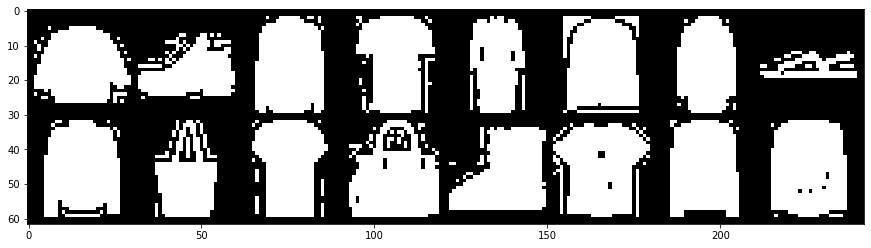

In [13]:
visual_loader = torch.utils.data.DataLoader(train_split, batch_size=16)
batch = next(iter(visual_loader))
images, labels = batch
print("Visualization Sample:- ",images.shape, labels.shape)

grid = torchvision.utils.make_grid(images, nrow=8)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

print("labels text: ", end=" ")
for i, label in enumerate(labels):
    print(labels_text[label.item()], end=" | ")

# CNN Model Architecture

In [14]:
class PyTorchFMINSTCNN(nn.Module):
    
    def __init__(self):
        super(PyTorchFMINSTCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # Out Image: 28 * 28 * 32
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2) # Out Image: 14 * 14 * 32
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3), # Out Image: 12 * 12 * 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2) # 6 * 6 * 64
        )
                
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3), # 4 * 4 * 128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(4)
        )
        
        self.drop = nn.Dropout2d(0.1)        
        self.fc1 = nn.Linear(in_features=1 * 1 * 128, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.drop(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        
        return out

In [15]:
model = PyTorchFMINSTCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

PyTorchFMINSTCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=4, stride=4, padding=0)
  )
  (drop): Dropout2d(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)


# Model Training

In [16]:
num_epochs = 20
count = 0
# Keeping Records
loss_list = []
iteration_list = []
accuracy_list = []
best_acc = 0.0

# Keeping Records per class
predictions_list = []
labels_list = []

In [17]:
for epoch in range(num_epochs):
    for images, labels in train_data_loader:
        
        # GPU memory transfer
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(batch_size, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward prop 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Resetting Gradient to Zero
        optimizer.zero_grad()
        
        # Loss gradient Calculation
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
        count += 1
    
    # Testing the model
    
        if not (count % 50):
            total = 0
            correct = 0
        
            for images, labels in test_data_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(batch_size, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Batch: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))
            if best_acc >= accuracy:
                learning_rate /= 10 # Adaptive LR
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                print("New Learning Rate: ", learning_rate)
            else:
                best_acc = accuracy

Batch: 500, Loss: 0.34040719270706177, Accuracy: 88.3499984741211%
Batch: 1000, Loss: 0.22316423058509827, Accuracy: 90.62999725341797%
Batch: 1500, Loss: 0.24204885959625244, Accuracy: 91.77999877929688%
Batch: 2000, Loss: 0.21761149168014526, Accuracy: 90.82999420166016%
New Learning Rate:  0.001
Batch: 2500, Loss: 0.18463100492954254, Accuracy: 92.86000061035156%
Batch: 3000, Loss: 0.16067670285701752, Accuracy: 92.8699951171875%
Batch: 3500, Loss: 0.15862636268138885, Accuracy: 92.72999572753906%
New Learning Rate:  0.0001
Batch: 4000, Loss: 0.1254349648952484, Accuracy: 93.14999389648438%
Batch: 4500, Loss: 0.15982674062252045, Accuracy: 93.25%
Batch: 5000, Loss: 0.13261626660823822, Accuracy: 93.14999389648438%
New Learning Rate:  1e-05
Batch: 5500, Loss: 0.12095032632350922, Accuracy: 93.33999633789062%
Batch: 6000, Loss: 0.15196461975574493, Accuracy: 93.0999984741211%
New Learning Rate:  1.0000000000000002e-06


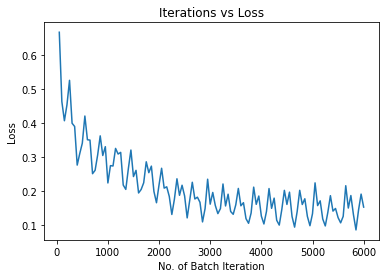

In [18]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Batch Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

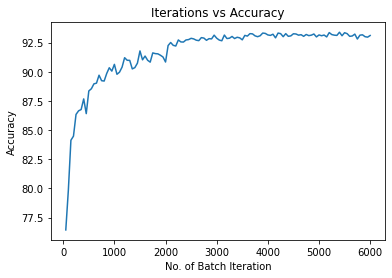

In [19]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Batch Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

# Evaluation per class

In [20]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad(): # Deattaching Gradient cals
    for images, labels in test_data_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(labels_text[i], class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 87.58%
Accuracy of Trouser: 99.61%
Accuracy of Pullover: 89.00%
Accuracy of Dress: 92.62%
Accuracy of Coat: 89.37%
Accuracy of Sandal: 97.78%
Accuracy of Shirt: 79.67%
Accuracy of Sneaker: 96.39%
Accuracy of Bag: 98.44%
Accuracy of Ankle Boot: 97.29%


In [21]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [22]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix


confusion_matrix(labels_l, predictions_l)
print("Classification report :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report :
              precision    recall  f1-score   support

           0       0.85      0.88      0.86    120000
           1       0.99      0.99      0.99    120000
           2       0.89      0.87      0.88    120000
           3       0.92      0.92      0.92    120000
           4       0.86      0.88      0.87    120000
           5       0.99      0.97      0.98    120000
           6       0.78      0.73      0.76    120000
           7       0.95      0.96      0.96    120000
           8       0.98      0.99      0.98    120000
           9       0.96      0.97      0.97    120000

    accuracy                           0.92   1200000
   macro avg       0.92      0.92      0.92   1200000
weighted avg       0.92      0.92      0.92   1200000




# References
* https://www.linkedin.com/learning/pytorch-essential-training-deep-learning
* https://colab.research.google.com/github/pytorch/ignite/blob/master/examples/notebooks/FashionMNIST.ipynb#scrollTo=AST_DtTC6psh